# Paradigm 05: Iterative Refinement Research Agent

This notebook implements the **Iterative Refinement (Diffusion-Based Reasoning)** paradigm from the Research Paradigms document.

## Core Concept

Iterative refinement applies a Generate-Critique-Revise loop to improve output quality:
- **Generate**: Create initial research and draft
- **Critique**: Identify weak claims, gaps, and inconsistencies
- **Revise**: Fix identified issues with targeted improvements
- **Converge**: Stop when quality is sufficient or max iterations reached

## Literature Validation

> "WebThinker, LongDPO, CycleResearcher... iterating between generating and refining outputs to achieve higher quality results. This is the only universally validated component across all paradigms." —Feasibility Report

## Technology Stack

- **LLM**: `gpt-5-mini-2025-08-07`
- **Web Search**: Tavily API
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [7]:
import os
import operator
import asyncio
from pathlib import Path
from typing import List, Annotated, TypedDict, Literal

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [8]:
# Initialize LLM and Tavily client
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
tavily_client = TavilyClient()

# Refinement Configuration
MAX_REVISIONS = 3  # Maximum critique-revise iterations
MIN_QUALITY_THRESHOLD = 7.0  # Stop if quality exceeds this (1-10 scale)

print(f"Using model: {MODEL_NAME}")
print(f"Max revisions: {MAX_REVISIONS}")
print(f"Quality threshold: {MIN_QUALITY_THRESHOLD}/10")

Using model: gpt-5-mini-2025-08-07
Max revisions: 3
Quality threshold: 7.0/10


## 2. State Definitions

In [9]:
class CritiqueIssue(BaseModel):
    """An issue identified during critique."""
    issue_type: str = Field(description="Type: weak_claim, missing_evidence, logical_gap, unclear")
    location: str = Field(description="Where in the text this issue appears")
    description: str = Field(description="Description of the issue")
    suggestion: str = Field(description="Suggested fix")

class CritiqueResult(BaseModel):
    """Result of critique analysis."""
    issues: List[CritiqueIssue] = Field(default_factory=list)
    overall_quality: float = Field(description="Quality score 1-10")
    summary: str = Field(description="Summary of critique")

In [10]:
class IterativeRefinementState(TypedDict):
    """State for the Iterative Refinement Research Agent."""
    # Input
    question: str

    # Research phase (accumulated across all iterations)
    search_results: Annotated[List[str], operator.add]
    source_urls: Annotated[List[str], operator.add]

    # Draft management
    current_draft: str
    draft_history: Annotated[List[str], operator.add]  # Track all versions

    # Critique tracking
    current_critique: str
    critique_history: Annotated[List[str], operator.add]
    weak_claims: List[str]  # Claims that need evidence (extracted from critique)
    
    # Targeted evidence - REPLACED each iteration (not accumulated)
    # This allows revise_draft to use ONLY the new evidence, not old results
    targeted_evidence: List[str]
    
    revision_count: int
    quality_scores: Annotated[List[float], operator.add]

    # Output
    final_report: str

## 3. Helper Functions

In [11]:
def search_web(query: str, max_results: int = 10) -> tuple[List[str], List[str]]:
    """Execute web search using Tavily. Returns (results, urls)."""
    try:
        if len(query) > 400:
            query = query[:400]
        
        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )
        
        results = []
        urls = []
        
        if response.get("answer"):
            results.append(f"Summary: {response['answer']}")
        
        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            results.append(f"- {r.get('title', 'No title')}: {r.get('content', '')[:500]}... (Source: {url})")
        
        return results, urls
    except Exception as e:
        return [f"Search error: {str(e)}"], []

## 4. Node Functions

In [12]:
# Prompts
RESEARCH_PROMPT = """You are a research expert. Conduct comprehensive research on this question.

Question: {question}

Generate 5 focused search queries to gather information from different angles.
Return ONLY the search queries, one per line.
"""

DRAFT_PROMPT = """You are a research analyst writing a comprehensive report.

Question: {question}

Research Findings:
{research_findings}

Write a detailed research report (1000-1500 words) that:
1. Directly addresses the research question
2. Synthesizes findings from multiple sources
3. Provides evidence for all claims
4. Includes proper citations
5. Acknowledges limitations or uncertainties

Structure with clear sections and be comprehensive.
"""

CRITIQUE_PROMPT = """You are a critical reviewer evaluating a research report.

Original Question: {question}

Report to Critique:
{draft}

Analyze this report and identify issues. For EACH issue you find:

1. WEAK CLAIMS: Statements without sufficient evidence
2. MISSING EVIDENCE: Important points that need citations/data
3. LOGICAL GAPS: Missing connections or reasoning holes
4. UNCLEAR SECTIONS: Confusing or ambiguous passages

You MUST format your response EXACTLY as follows:

QUALITY_SCORE: [1-10]

WEAK_CLAIMS:
- "[exact quote from report that needs evidence]" | SEARCH: [specific search query to find evidence]
- "[another weak claim]" | SEARCH: [search query]

OTHER_ISSUES:
- [Type]: "[Location]" - [Description]. Suggestion: [Fix]

SUMMARY: [Overall assessment of the report]

IMPORTANT: For each weak claim, provide a SPECIFIC search query that would find evidence to support or refute it.
"""

TARGETED_RESEARCH_PROMPT = """Based on critique feedback, conduct targeted research to find evidence for specific weak claims.

Original Question: {question}

Weak claims that need evidence:
{weak_claims}

Generate 1-2 focused search queries per weak claim to find supporting evidence.
Return ONLY the search queries, one per line.
"""

REVISE_PROMPT = """You are a research analyst revising a report based on critical feedback AND new evidence.

Original Question: {question}

Current Draft:
{current_draft}

Critique Feedback:
{critique}

NEW EVIDENCE FOUND (use this to fix weak claims):
{new_evidence}

Revise the report to address ALL identified issues:
- Replace weak claims with evidence-backed statements using the NEW EVIDENCE provided
- Add proper citations from the new sources
- Fill logical gaps with explanations
- Clarify unclear sections

IMPORTANT: Use the NEW EVIDENCE to substantiate claims. Do NOT make up evidence.
Maintain the overall structure but improve quality. Do NOT shorten the report.
Output the complete revised report.
"""

In [13]:
async def conduct_research(state: IterativeRefinementState) -> dict:
    """Conduct initial research phase."""
    question = state["question"]
    
    print(f"\n{'='*60}")
    print(f"Research Phase")
    print(f"{'='*60}")
    
    # Generate search queries
    prompt = RESEARCH_PROMPT.format(question=question)
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    queries = [q.strip() for q in response.content.split("\n") if q.strip()][:5]
    
    # Execute searches
    all_results = []
    all_urls = []
    
    for query in queries:
        print(f"  Searching: {query[:50]}...")
        results, urls = search_web(query)
        all_results.extend(results)
        all_urls.extend(urls)
    
    print(f"  Collected {len(all_results)} results from {len(set(all_urls))} sources")
    
    return {
        "search_results": all_results,
        "source_urls": all_urls,
        "revision_count": 0
    }

In [14]:
async def generate_draft(state: IterativeRefinementState) -> dict:
    """Generate initial draft from research."""
    question = state["question"]
    search_results = state.get("search_results", [])
    
    print(f"\n--- Generating Initial Draft ---")
    
    # Token efficiency: limit by character count, not just item count
    results_for_draft = []
    total_chars = 0
    for result in search_results:
        if total_chars + len(result) > 10000:  # ~10k chars max
            break
        results_for_draft.append(result)
        total_chars += len(result)
    
    print(f"  Using {len(results_for_draft)}/{len(search_results)} results ({total_chars} chars)")
    
    prompt = DRAFT_PROMPT.format(
        question=question,
        research_findings="\n\n".join(results_for_draft)
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    print(f"  Draft generated: {len(response.content)} characters")
    
    return {
        "current_draft": response.content,
        "draft_history": [f"V0 (Initial): {len(response.content)} chars"],
        "targeted_evidence": []  # Initialize empty for first draft
    }

In [15]:
def parse_weak_claims_and_queries(critique: str) -> tuple[List[str], List[str]]:
    """Parse weak claims and their search queries from critique output.
    
    Returns:
        tuple: (list of weak claim texts, list of search queries)
    """
    import re
    
    weak_claims = []
    search_queries = []
    
    # Find the WEAK_CLAIMS section
    weak_section_match = re.search(r'WEAK_CLAIMS:\s*\n(.*?)(?=\n(?:OTHER_ISSUES|SUMMARY)|\Z)', critique, re.DOTALL)
    
    if weak_section_match:
        weak_section = weak_section_match.group(1)
        # Parse each line: - "[claim]" | SEARCH: [query]
        pattern = r'-\s*"([^"]+)"\s*\|\s*SEARCH:\s*(.+?)(?=\n-|\Z)'
        matches = re.findall(pattern, weak_section, re.DOTALL)
        
        for claim, query in matches:
            weak_claims.append(claim.strip())
            search_queries.append(query.strip())
    
    return weak_claims, search_queries


async def critique_draft(state: IterativeRefinementState) -> dict:
    """Critique the current draft and extract weak claims for targeted research."""
    question = state["question"]
    current_draft = state.get("current_draft", "")
    revision_count = state.get("revision_count", 0)
    
    print(f"\n--- Critique Phase (Revision {revision_count}) ---")
    
    # Token efficiency: truncate very long drafts for critique
    draft_for_critique = current_draft
    if len(current_draft) > 12000:
        draft_for_critique = current_draft[:12000] + "\n\n[... truncated for critique ...]"
        print(f"  (Draft truncated from {len(current_draft)} to 12000 chars for critique)")
    
    prompt = CRITIQUE_PROMPT.format(
        question=question,
        draft=draft_for_critique
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    critique = response.content
    
    # Extract quality score
    quality_score = 5.0  # Default
    try:
        import re
        match = re.search(r'QUALITY_SCORE:\s*(\d+\.?\d*)', critique)
        if match:
            quality_score = float(match.group(1))
    except:
        pass
    
    # Extract weak claims and their search queries
    weak_claims, search_queries = parse_weak_claims_and_queries(critique)
    
    print(f"  Quality score: {quality_score}/10")
    print(f"  Weak claims identified: {len(weak_claims)}")
    if weak_claims:
        for i, claim in enumerate(weak_claims[:3]):  # Show first 3
            print(f"    {i+1}. \"{claim[:50]}...\"")
    
    return {
        "current_critique": critique,
        "critique_history": [f"R{revision_count}: Score {quality_score}/10, {len(weak_claims)} weak claims"],
        "quality_scores": [quality_score],
        "weak_claims": weak_claims  # Store for targeted research
    }

In [16]:
async def targeted_research(state: IterativeRefinementState) -> dict:
    """Conduct targeted research to find evidence for weak claims identified in critique.
    
    This is the KEY differentiator from naive revision - we actually SEARCH for evidence
    rather than asking the LLM to hallucinate it.
    
    Returns:
        - targeted_evidence: REPLACES previous (only new evidence for this revision)
        - search_results: ACCUMULATES (for source URL tracking)
        - source_urls: ACCUMULATES (for citation)
    """
    question = state["question"]
    critique = state.get("current_critique", "")
    weak_claims = state.get("weak_claims", [])
    
    print(f"\n--- Targeted Research Phase ---")
    
    if not weak_claims:
        print("  No weak claims to research - skipping targeted research")
        return {
            "targeted_evidence": [],  # Clear previous evidence
            "search_results": [],
            "source_urls": []
        }
    
    # Extract search queries from the critique (they're embedded with the weak claims)
    _, search_queries = parse_weak_claims_and_queries(critique)
    
    # If no queries extracted, generate them from the weak claims directly
    if not search_queries and weak_claims:
        print("  Generating search queries for weak claims...")
        prompt = TARGETED_RESEARCH_PROMPT.format(
            question=question,
            weak_claims="\n".join([f"- {claim}" for claim in weak_claims[:5]])  # Limit to 5
        )
        response = await llm.ainvoke([HumanMessage(content=prompt)])
        search_queries = [q.strip() for q in response.content.split("\n") if q.strip()][:6]
    
    # Execute targeted searches (limit to prevent token explosion)
    queries_to_run = search_queries[:4]  # Max 4 targeted searches per revision
    all_results = []
    all_urls = []
    
    print(f"  Running {len(queries_to_run)} targeted searches for weak claims:")
    for query in queries_to_run:
        print(f"    - {query[:60]}...")
        results, urls = search_web(query, max_results=5)  # Fewer results per query
        all_results.extend(results)
        all_urls.extend(urls)
    
    print(f"  Collected {len(all_results)} new results from {len(set(all_urls))} sources")
    
    return {
        "targeted_evidence": all_results,  # REPLACE - only this round's evidence
        "search_results": all_results,     # ACCUMULATE - for overall tracking
        "source_urls": all_urls            # ACCUMULATE - for citations
    }


def should_continue_refining(state: IterativeRefinementState) -> Literal["targeted_research", "finalize"]:
    """Decide whether to continue refining (with research) or finalize."""
    revision_count = state.get("revision_count", 0)
    quality_scores = state.get("quality_scores", [])
    
    latest_score = quality_scores[-1] if quality_scores else 0
    
    # Stop conditions
    if revision_count >= MAX_REVISIONS:
        print(f"  Max revisions ({MAX_REVISIONS}) reached. Finalizing.")
        return "finalize"
    
    if latest_score >= MIN_QUALITY_THRESHOLD:
        print(f"  Quality threshold ({MIN_QUALITY_THRESHOLD}) met. Finalizing.")
        return "finalize"
    
    print(f"  Continuing refinement (score {latest_score} < threshold {MIN_QUALITY_THRESHOLD})")
    return "targeted_research"  # Go to targeted research, then revision

In [17]:
async def revise_draft(state: IterativeRefinementState) -> dict:
    """Revise the draft based on critique AND new evidence from targeted research.
    
    This is the key improvement - we use ACTUAL search results to fix weak claims,
    not just asking the LLM to make something up.
    """
    question = state["question"]
    current_draft = state.get("current_draft", "")
    critique = state.get("current_critique", "")
    targeted_evidence = state.get("targeted_evidence", [])  # Use ONLY new evidence
    revision_count = state.get("revision_count", 0)
    
    print(f"\n--- Revision Phase ({revision_count + 1}/{MAX_REVISIONS}) ---")
    
    # Use targeted_evidence (only from this round's research)
    new_evidence = "\n\n".join(targeted_evidence) if targeted_evidence else "No additional evidence found."
    
    # Token efficiency: truncate if evidence is very long
    if len(new_evidence) > 8000:
        new_evidence = new_evidence[:8000] + "\n\n[... additional evidence truncated ...]"
        print(f"  (Evidence truncated to 8000 chars)")
    
    # Token efficiency: truncate very long drafts
    draft_for_revision = current_draft
    if len(current_draft) > 10000:
        # Keep intro and conclusion, truncate middle
        draft_for_revision = current_draft[:5000] + "\n\n[... middle sections ...]" + current_draft[-3000:]
        print(f"  (Draft truncated from {len(current_draft)} to ~8000 chars for revision)")
    
    prompt = REVISE_PROMPT.format(
        question=question,
        current_draft=draft_for_revision,
        critique=critique,
        new_evidence=new_evidence
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    revised_draft = response.content
    
    # Calculate improvement
    len_change = len(revised_draft) - len(current_draft)
    print(f"  Revised draft: {len(revised_draft)} chars ({'+' if len_change >= 0 else ''}{len_change})")
    print(f"  Evidence used: {len(targeted_evidence)} search results from targeted research")
    
    return {
        "current_draft": revised_draft,
        "draft_history": [f"V{revision_count + 1}: {len(revised_draft)} chars (with {len(targeted_evidence)} new sources)"],
        "revision_count": revision_count + 1
    }

In [18]:
async def finalize_report(state: IterativeRefinementState) -> dict:
    """Finalize the report."""
    current_draft = state.get("current_draft", "")
    revision_count = state.get("revision_count", 0)
    quality_scores = state.get("quality_scores", [])
    
    print(f"\n{'='*60}")
    print(f"Report Finalized")
    print(f"{'='*60}")
    print(f"  Total revisions: {revision_count}")
    print(f"  Quality progression: {' -> '.join([f'{s:.1f}' for s in quality_scores])}")
    print(f"  Final length: {len(current_draft)} characters")
    
    return {
        "final_report": current_draft
    }

## 5. Graph Construction

In [19]:
# Build the Iterative Refinement Research Agent graph
# 
# Flow: 
#   START -> conduct_research -> generate_draft -> critique_draft
#                                                       |
#                         +-----------------------------+
#                         |                             |
#                         v                             v
#                  targeted_research              finalize_report -> END
#                         |                        (if quality threshold met)
#                         v
#                    revise_draft
#                         |
#                         v
#                   critique_draft (loop)

ir_builder = StateGraph(IterativeRefinementState)

# Add nodes
ir_builder.add_node("conduct_research", conduct_research)
ir_builder.add_node("generate_draft", generate_draft)
ir_builder.add_node("critique_draft", critique_draft)
ir_builder.add_node("targeted_research", targeted_research)  # NEW: Research for weak claims
ir_builder.add_node("revise_draft", revise_draft)
ir_builder.add_node("finalize_report", finalize_report)

# Add edges
ir_builder.add_edge(START, "conduct_research")
ir_builder.add_edge("conduct_research", "generate_draft")
ir_builder.add_edge("generate_draft", "critique_draft")

# Conditional edge: targeted research (then revise) or finalize
ir_builder.add_conditional_edges(
    "critique_draft",
    should_continue_refining,
    {
        "targeted_research": "targeted_research",  # Research weak claims first
        "finalize": "finalize_report"
    }
)

# targeted_research -> revise_draft -> critique_draft (loop)
ir_builder.add_edge("targeted_research", "revise_draft")
ir_builder.add_edge("revise_draft", "critique_draft")

ir_builder.add_edge("finalize_report", END)

# Compile
iterative_refinement_graph = ir_builder.compile()

print("Iterative Refinement Research Agent compiled successfully")
print("\nKey improvement: Targeted research between critique and revision")
print("This ensures weak claims are fixed with ACTUAL evidence, not hallucination.")

Iterative Refinement Research Agent compiled successfully

Key improvement: Targeted research between critique and revision
This ensures weak claims are fixed with ACTUAL evidence, not hallucination.


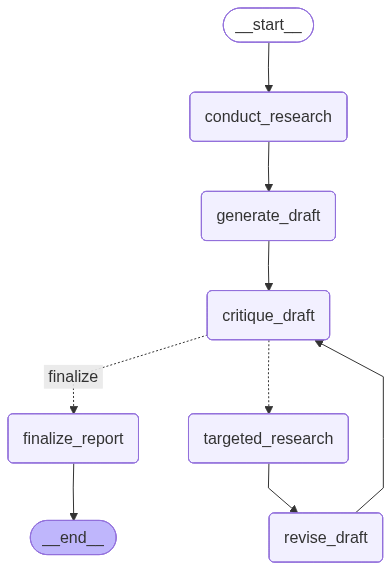

In [20]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(iterative_refinement_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 6. Agent Wrapper for Evaluation

In [ ]:
async def iterative_refinement_agent_async(inputs: dict) -> dict:
    """
    Async version of the Iterative Refinement research agent.
    Use this version when calling from Jupyter notebooks.
    """
    question = inputs.get("question", "")
    
    result = await iterative_refinement_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 50}
    )
    
    return {
        "output": result.get("final_report", ""),
        "revision_count": result.get("revision_count", 0),
        "quality_scores": result.get("quality_scores", []),
        "source_urls": result.get("source_urls", [])
    }


def iterative_refinement_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for Iterative Refinement research agent.
    
    Compatible with evaluation harness.
    
    Args:
        inputs: Dictionary with 'question' key
        
    Returns:
        Dictionary with 'output' key containing final report
    """
    question = inputs.get("question", "")
    
    async def _execute():
        return await iterative_refinement_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 50}
        )
    
    # Check if we're already in an async context (e.g., Jupyter notebook)
    try:
        loop = asyncio.get_running_loop()
        # We're in an event loop - need to run in a separate thread
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        # No event loop running, safe to use asyncio.run
        result = asyncio.run(_execute())
    
    return {
        "output": result.get("final_report", ""),
        "revision_count": result.get("revision_count", 0),
        "quality_scores": result.get("quality_scores", []),
        "source_urls": result.get("source_urls", [])
    }

## 7. Manual Test

Run this cell to verify the agent works correctly with a simple test question.

In [ ]:
# Simple test
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Iterative Refinement Agent with question:\n{test_question}\n")
print("Running iterative research (this may take several minutes)...\n")

try:
    # Use the async version in notebooks to avoid event loop conflicts
    result = await iterative_refinement_agent_async({"question": test_question})
    
    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:3000] + "..." if len(result["output"]) > 3000 else result["output"])
    print("\n" + "=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Total revisions: {result.get('revision_count', 0)}")
    print(f"Quality progression: {result.get('quality_scores', [])}")
    print(f"Unique sources: {len(set(result.get('source_urls', [])))}")
    print("Agent test PASSED ✓")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

## 8. Evaluation Harness Integration

Once the manual test passes, uncomment and run the cells below for full evaluation.

In [ ]:
# Import evaluation harness and metrics
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness, 
    fact_recall, 
    citation_precision,
    coherence_judge, 
    depth_judge, 
    relevance_judge,
    minimum_sources_check
)

# Initialize harness with the golden test dataset
harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized successfully!")
print(f"Dataset: {harness.dataset_path}")
print(f"LangSmith dataset name: {harness.langsmith_dataset_name}")

In [ ]:
# Full Evaluation on All 20 Questions
# ⚠️ EXPENSIVE - Only uncomment when ready for full evaluation
# Uncomment to run:

# # Define comprehensive evaluator suite
# evaluators = [
#     fact_recall,              # Required facts coverage
#     citation_precision,       # Citation URL validity
#     minimum_sources_check,    # Minimum source count
#     coherence_judge,          # Logical structure
#     depth_judge,              # Analysis depth
#     relevance_judge,          # Addresses question
# ]
# 
# # Run full evaluation
# print("Starting FULL evaluation on all 20 questions...")
# print("Iterative Refinement Agent - this will take 1-2 hours.")
# print("=" * 80 + "\n")
# 
# results = harness.run_evaluation(
#     agent_fn=iterative_refinement_agent,
#     evaluators=evaluators,
#     experiment_name="iterative_refinement_v1",
#     monte_carlo_runs=1,  # Single run to reduce cost
#     max_concurrency=2,   # Lower concurrency for stability
#     description="Iterative Refinement paradigm evaluation on all difficulty tiers"
# )
# 
# # Display comprehensive results
# print("\n" + "=" * 80)
# print("FULL EVALUATION RESULTS")
# print("=" * 80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions evaluated: {results.num_questions}")
# print(f"Runs per question: {results.num_runs}")
# 
# print(f"\n{'Metric':<30} {'Mean':<10}")
# print("-" * 40)
# for metric_name in sorted(results.metrics.keys()):
#     if not metric_name.endswith('_std'):
#         value = results.metrics.get(metric_name, 0)
#         print(f"{metric_name:<30} {value:<10.3f}")
# 
# # Save results to file
# import json
# from datetime import datetime
# 
# results_file = Path("../results") / f"iterative_refinement_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
# results_file.parent.mkdir(exist_ok=True)
# 
# with open(results_file, 'w') as f:
#     json.dump({
#         "experiment_name": results.experiment_name,
#         "num_questions": results.num_questions,
#         "num_runs": results.num_runs,
#         "metrics": results.metrics,
#         "per_question": results.per_question_results
#     }, f, indent=2)
# 
# print(f"\nResults saved to: {results_file}")

print("Full evaluation cell ready. Uncomment to run when ready.")